In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm


In [3]:

# Load MovieLens Small dataset
data = pd.read_csv("../../datasets/ml-latest-small/ratings.csv", sep=",")
#data = pd.read_csv("../../datasets/ml-1m/ratings.csv", sep=",", names=["userId","movieId","rating","timestamp"])

#data = pd.read_csv("ratings.csv", sep=",")
#prefs = pd.read_csv("drive/MyDrive/PycharmProjects/datasets/ml-latest-small/ratings.csv", sep=",")

data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
data.shape

(100836, 4)

In [4]:
# Map user and movie IDs to unique indices
user_ids = data['userId'].unique()
movie_ids = data['movieId'].unique()

user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

data['userId'] = data['userId'].map(user_mapping)
data['movieId'] = data['movieId'].map(movie_mapping)

In [8]:
class MovieLensDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe[['userId', 'movieId']].values
        self.ratings = dataframe['rating'].values.astype(np.float32)
        
        # It is faster (at least 2x) to use numpy arrays instead of a dataframe as below
        # and access the data in __getitem__ using iloc
        #self.data = dataframe[['userId', 'movieId']]
        #self.ratings = dataframe['rating']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.LongTensor(self.data[idx]), torch.FloatTensor([self.ratings[idx]])


In [5]:
# Define the matrix factorization model
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.linear = nn.Linear(2*embedding_size, 1)

    def forward(self, X):
        user_embedding = self.user_embedding(X[:,0])
        movie_embedding = self.movie_embedding(X[:,1])
        
        prediction = torch.sum(user_embedding * movie_embedding, dim=1)
     

        return prediction

In [9]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.1)

# Initialize dataset and data loaders
train_dataset = MovieLensDataset(train_data)
test_dataset = MovieLensDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

In [10]:
a = torch.Tensor([[-0.4266, -0.4373, -0.4427, -0.7173,  0.1183],
        [ 0.5720,  1.3187, -1.5295, -1.7553,  0.9981]])
b = torch.Tensor([[-0.1013,  0.8980, -0.3187,  0.5583, -1.4790],
        [ 0.1501,  0.8112, -0.4382,  0.5182,  0.3780]])
torch.sum(a * b, dim=1)

tensor([-0.7838,  1.2935])

In [22]:
X.shape

torch.Size([90752, 2])

In [13]:
# Initialize the model and optimizer
num_users = len(user_ids)
num_movies = len(movie_ids)
model = MatrixFactorization(num_users, num_movies, embedding_size=5)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

total_loss = 0.0
absolute_errors = []
num_epochs = 10

batch_size = 32
# Note: In order to test the effectives of mini-batching or stochastic gradient descent, 
# you can try to increase batch_size up to n_samples. In that case the execution time of
# each epoch will begin to decrease, however, since updates are done after each batch,
# there will be a less number of updates in each epoch which will slow down convergence. On the other hand,
# if batch_size is smaller (such as 32) then there will be n_samples/batch_size
# updates in each epoch. This type of gradient descent is called mini-batch or stochastic gradient descent.

n_samples = len(train_data)
X = torch.tensor(train_data[['userId', 'movieId']].values)
y = torch.tensor(train_data['rating'].values.astype(np.float32))

import time
start = time.time()

for epoch in range(num_epochs):
    permutation = torch.randperm(n_samples)
    absolute_errors = []

    for i in range(0, n_samples, batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X[indices], y[indices]


        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        absolute_errors.extend(torch.abs(predictions - batch_y).tolist())
    
    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss}")
        print(f"Train MAE: {np.mean(absolute_errors)}")

end = time.time()
print("Elapsed time:", end - start)

    


Epoch 1/10, Loss: 6.9716691970825195
Train MAE: 3.031537237191935
Epoch 2/10, Loss: 3.9866135120391846
Train MAE: 1.379067447373436
Epoch 3/10, Loss: 0.7808533310890198
Train MAE: 1.0143476741379245
Epoch 4/10, Loss: 1.078995943069458
Train MAE: 0.8823041310796595
Epoch 5/10, Loss: 1.5398935079574585
Train MAE: 0.8123732865127973
Epoch 6/10, Loss: 1.1802263259887695
Train MAE: 0.7677551447157716
Epoch 7/10, Loss: 1.0619089603424072
Train MAE: 0.736329366448066
Epoch 8/10, Loss: 1.17452073097229
Train MAE: 0.7141292522509014
Epoch 9/10, Loss: 0.5432531833648682
Train MAE: 0.6954182582360275
Epoch 10/10, Loss: 0.6245182156562805
Train MAE: 0.6815377668469713
Elapsed time: 23.263670444488525


In [58]:
train_data.shape

(90752, 4)

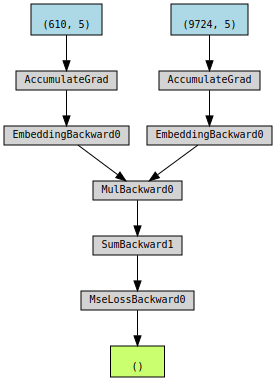

In [14]:
make_dot(loss)

In [79]:
X_test = torch.tensor(test_data[['userId', 'movieId']].values)
y_test = torch.tensor(test_data['rating'].values.astype(np.float32))

model.eval()
test_loss = 0.0
absolute_errors = []
with torch.no_grad():
    predictions = model(X_test)
    loss = criterion(predictions, y_test)
    

print(f"Test Loss: {test_loss / len(X_test)}")
print(f"Test MAE: {np.abs((predictions - y_test).tolist()).mean()}")

Test Loss: 0.0
Test MAE: 0.8359882413590299


In [ ]:
# Initialize the model and optimizer
num_users = len(user_ids)
num_movies = len(movie_ids)
model = MatrixFactorization(num_users, num_movies, embedding_size=10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")
#model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# Training loop
num_epochs = 20

import time
start = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    absolute_errors = []

    for batch_idx, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        #X = X.to(device)
        #y = y.to(device)
        predictions = model(X).squeeze()
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        absolute_errors.extend(torch.abs(predictions - y).tolist()[0])
        


    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")
    print(f"Train MAE: {np.mean(absolute_errors)}")

end = time.time()
print("Elapsed time:", end - start)
